# Modelagem SEIR
Neste notebook está implementado o modelo SEIR de Zhilan Feng. Que inclui quarentena, e hospitalizações

\begin{align}
\frac{dS}{dt}&=-\beta S (I+(1-\rho)H)\\
\frac{dE}{dt}&= \beta S (I+(1-\rho)H)-(\chi+\alpha)E\\
\frac{dQ}{dt}&=\chi E -\alpha Q\\
\frac{dI}{dt}&= \alpha E - (\phi+\delta)I\\
\frac{dH}{dt}&= \alpha Q +\phi I -\delta H\\
\frac{dR}{dt}&= \delta I +\delta H
\end{align}

Denotando o tamanho total da epidemia por $Y_e(t)=E(t)+Q(t)+I(t)+H(t)$, podemos escrever:

\begin{align}
\nonumber \frac{dY_e}{dt}&= \frac{dE}{dt}+\frac{dQ}{dt}+\frac{dI}{dt}+\frac{dH}{dt}\\
\label{ye}&=\beta S (I(1-\rho)H) -\delta(I+H)
\end{align}


In [170]:
from scipy.integrate import odeint
import pandas as pd
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
import humanizer_portugues as hp
import seaborn as sns
from datetime import timedelta
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [14]:
def seqihr(y,t,*params):
    S,E,Q,I,H,R = y
    chi,phi,beta,rho,delta,alpha = params
    return[
        -beta*S*(I+(1-rho)*H), #dS/dt
        beta*S*(I+(1-rho)*H) - (chi+alpha)*E,#dE/dt
        chi*E -alpha*Q,#dQ/dt
        alpha*E - (phi+delta)*I,#dI/dt
        alpha*Q + phi*I -delta*H,#dH/dt
        delta*I + delta*H,#dR/dt
    ]

In [15]:
chi=.05  # Taxa de quarentenação
phi=.01 # Taxa de Hospitalização
beta=.2 #taxa de Transmissão
rho=.6 # Atenuação da transmissão quando hospitalizado
delta=1/10 # Taxa de recuperação hospitalar
alpha=1/3 # Taxa de incubaçao

In [16]:
inits = [0.9,.1,0,0,0,0]
trange = arange(0,100,.1)
res = odeint(seqihr,inits,trange,args=(chi,phi,beta,rho,delta,alpha))

In [17]:

@interact(chi=(0,.1, 0.01),phi=(0,.1,.005),beta=(0,.5,.05),rho=(0,1,.1),delta=(0,1,.05),alpha=(0,1,0.01))
def plota_simulação(chi=0.05,phi=.01,beta=.2,rho=.6,delta=.1,alpha=.33):
    res = odeint(seqihr,inits,trange,args=(chi,phi,beta,rho,delta,alpha))
    fig, ax = subplots(1,1, figsize=(15,10))
    ax.plot(trange,res[:,1:-1])
    ax.set_ylabel('Fração da População')
    ax.set_xlabel('Tempo (dias)')
    ax.grid()
    ax.legend(['Exposto','Quar','Inf','Hosp']);

interactive(children=(FloatSlider(value=0.05, description='chi', max=0.1, step=0.01), FloatSlider(value=0.01, …

## Adicionando Assintomáticos
![Diagrama de blocos](seqiahr.jpg "Modelo")
O modelo de Feng não é apropriado para representar a epidemia da COVID-19. Vamos Modificá-lo para incluir entre outras coisas, os assintomáticos. Para simplificar a notação vamos denotar por $\lambda=\beta(I\color{red}{+A}+(1-\rho)H)$, já incluindo os assintomáticos, $A$.

\begin{align}
\frac{dS}{dt}&=-\lambda S \\
\frac{dE}{dt}&= \lambda S -(\chi+\alpha)E\\
\frac{dQ}{dt}&=\chi E -\color{red}{(\phi+\delta)} Q\\
\frac{dI}{dt}&= \color{red}{(1-p)}\alpha E - (\phi+\delta)I\\
\color{red}{\frac{dA}{dt}}&= \color{red}{p\alpha E -\delta A}\\
\frac{dH}{dt}&= \color{red}{\phi} Q +\phi I -\delta H\\
\frac{dR}{dt}&= \delta I +\delta H \color{red}{+ \delta A +\delta Q}
\end{align}

Neste novo modelo alteramos mais algumas coisinhas resaltadas em vermelho acima. em primeiro lugar fizemos com que a taxa de hospitalização dos quarentenados, seja a mesma que a dos infectados e permitimos que se recuperem sem hospitalização. Além disso, para alimentar a classe dos Assintomáticos, definimos $p$ como a fração de assintomáticos na população. $R_0\approx$

In [552]:
def seqiahr(y,t,*params):
    S,E,I,A,H,R,C = y
    chi,phi,beta,rho,delta,alpha,p = params
    lamb = beta*S*(I+A+(1-rho)*H)
    return[
        -lamb*((1-chi)*S), #dS/dt
        lamb*((1-chi)*S) - alpha*E,#dE/dt
        (1-p)*alpha*E - (phi+delta)*I,#dI/dt
        p*alpha*E - delta*A,
        phi*I -delta*H,#dH/dt
        delta*I + delta*H+delta*A ,#dR/dt
        phi*I#(1-p)*alpha*E+ p*alpha*E # Casos acumulados
    ]

In [553]:
trange = arange(0,365,1)
inits = [0.99,0,1.0277e-6, 0.0,0,0,0]
N = 97.3e6
fat = 0.035 # case fatality rate
# sumario = open('cenarios.csv','w')
# sumario.write('R0,Quarentena,tamanho_total,hosp_total,hosp_pico,morte_total\n')

@interact(χ=(0,1, 0.05),φ=(0,.5,.01),β=(0,1.5,.02),ρ=(0,1,.1),δ=(0,1,.05),α=(0,1,0.01),p=(0,1,.05))
def plota_simulação(χ=0.0,φ=.01,β=.35,ρ=.6,δ=.1,α=10, p=.75):
    res = odeint(seqiahr,inits,trange,args=(χ,φ,β,ρ,δ,α,p))
    et = δ/β
    idx = np.argwhere(np.abs(res[:,0]-et)==min(np.abs(res[:,0]-et)))[0,0]
    fig, ax = subplots(1,1, figsize=(15,10))
    ax.plot(trange,res[:,1:-2]) 
    ax.set_ylim([0, 0.2])
    Ye = res[:,1:-2].sum(axis=1)
    Imax = (1-res[-1,0])*N # N-S(inf)
    Hosp_p = res[:,-2].max()*N # pico de Hospitalizações
    Hosp_tot = (φ*res[:,2]).sum()*N
    casos = (res[:,2]+res[:,-2]) # Casos notificados H+I
    casosT = Hosp_tot + ((1-p)*α*res[:,1]).sum()*N # N*sum(p*α*E)
    M = fat*Hosp_tot
    secax = ax.twinx()
    secax.plot(trange, Ye,'k:')
    secax.set_ylabel('Total prevalence fraction')
    ax.text(0,0.05,f"$R_0~{β/δ:.1f}$\n$p={p}$\n$\\rho={ρ}$\n$\\chi={χ*100}$%", fontsize=16)
    ax.text(110,.05,
            f"Tamanho total: {Imax:.2f} infectados\nHosp. pico: {Hosp_p:.1f}\nHosp. totais: {Hosp_tot:.1f}\nMortes: {M:.1f}"
            , fontsize=16)
    ax.vlines(trange[idx],0,0.2)#res[:,1:-1].max())
    ax.set_ylabel('Fração da População')
    ax.set_xlabel('Tempo (dias)')
    ax.grid()
#     sumario.write(f'{β/δ},{χ*100},{Imax},{Hosp_tot},{Hosp_p},{M}\n')
    ax.legend(['Exposto','Inf', 'Assintomático','Hosp']);
#     plt.savefig(f"export", dpi=300)

interactive(children=(FloatSlider(value=0.0, description='χ', max=1.0, step=0.05), FloatSlider(value=0.01, des…

In [450]:
sumario.close()
suma = pd.read_csv('cenarios.csv')
suma.drop_duplicates(inplace=True)
suma

,R0,Quarentena,tamanho_total,hosp_total,hosp_pico,morte_total
0,3.5,0.0,9.371322e+07,2.107742e+06,9.274032e+07,73770.952754
1,3.4,0.0,9.330362e+07,2.098433e+06,9.233072e+07,73445.151904
2,3.2,0.0,9.232554e+07,2.076204e+06,9.135264e+07,72667.141100
3,3.0,0.0,9.108278e+07,2.047959e+06,9.010988e+07,71678.567465
4,2.8,0.0,8.949176e+07,2.011800e+06,8.851886e+07,70412.990736
5,2.6,0.0,8.743679e+07,1.965096e+06,8.646389e+07,68778.353617
6,2.4,0.0,8.475429e+07,1.904130e+06,8.378139e+07,66644.540277
7,2.2,0.0,8.120770e+07,1.823525e+06,8.023475e+07,63823.367579
8,2.0,0.0,7.644520e+07,1.715276e+06,7.547166e+07,60034.642913
9,1.8,0.0,6.991597e+07,1.566660e+06,6.893016e+07,54833.082862


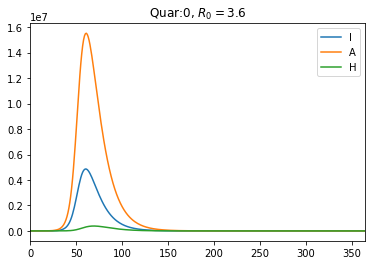

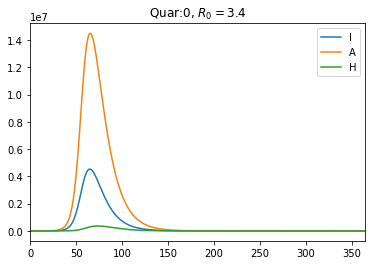

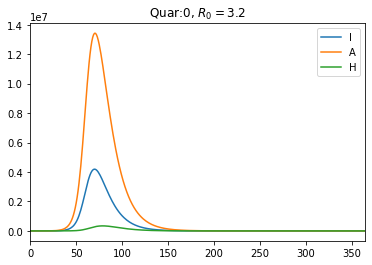

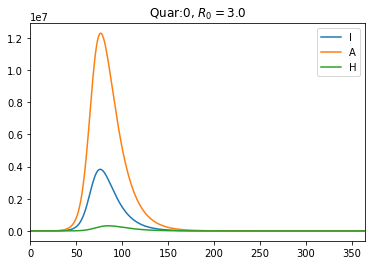

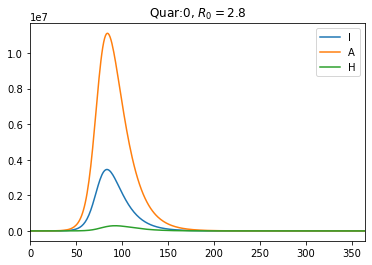

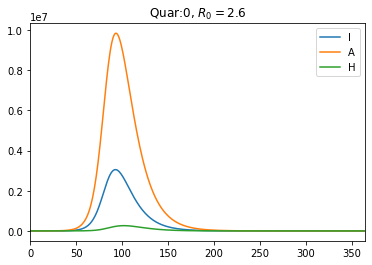

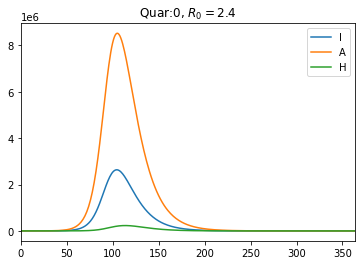

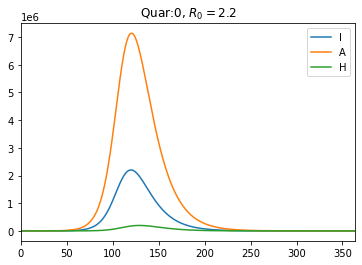

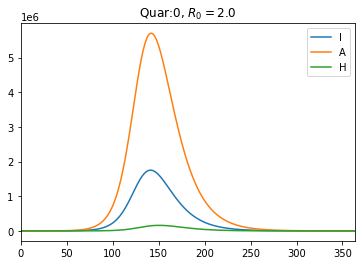

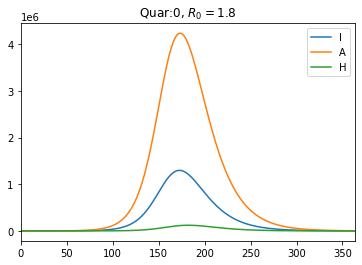

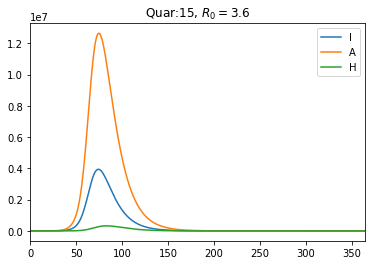

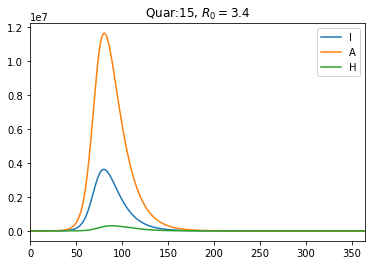

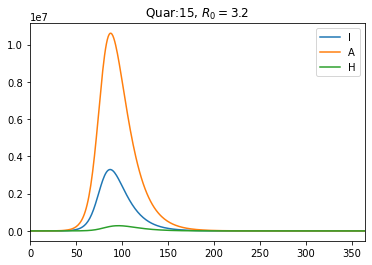

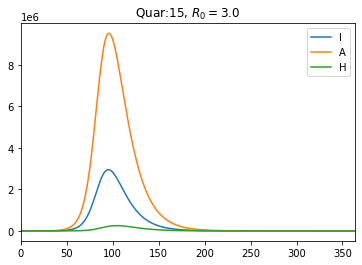

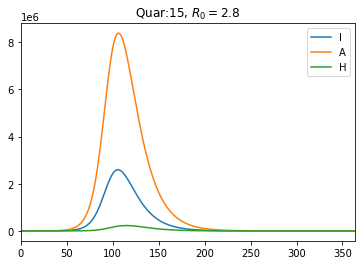

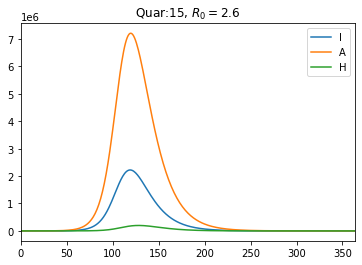

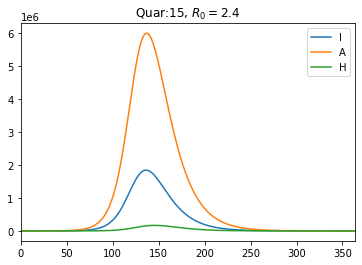

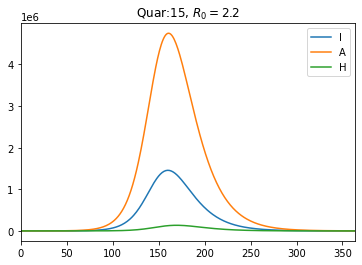

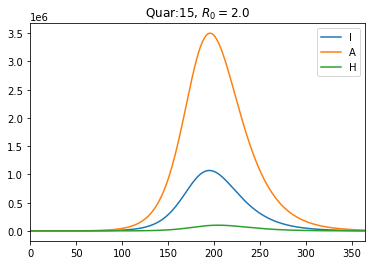

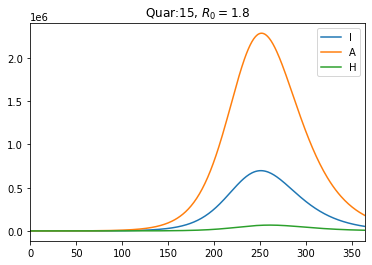

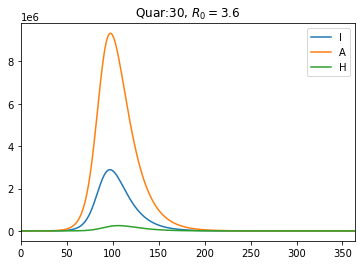

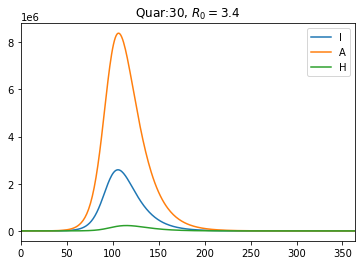

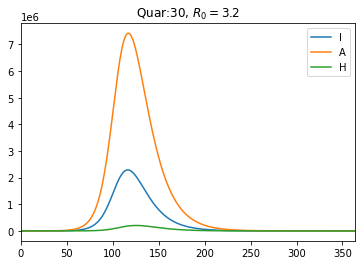

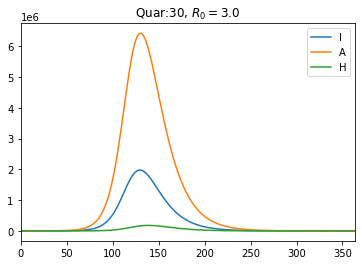

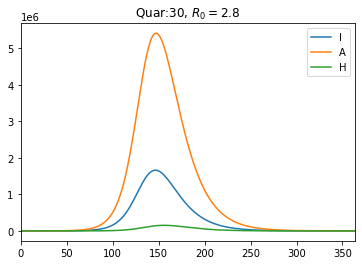

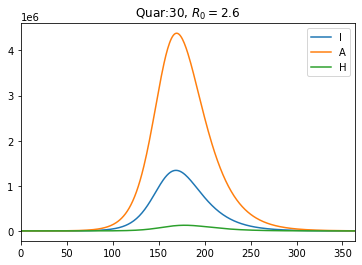

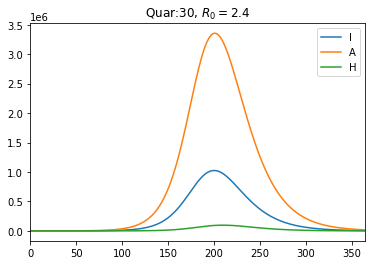

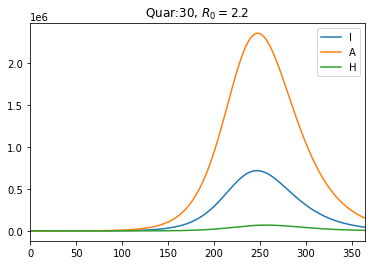

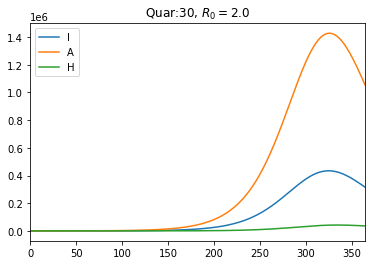

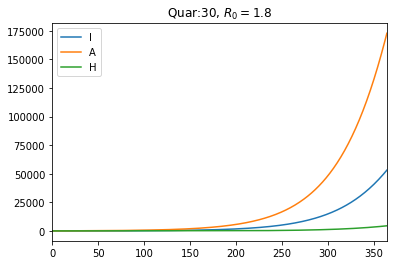

In [460]:
def save_data():
    χ=0.05;φ=.01;β=.25;ρ=.6;δ=.1;α=10; p=.75
    for q in [0,15,30]:
        i=1
        for R0 in np.arange(3.6,1.6, -0.2):
            res = odeint(seqiahr,inits,trange,args=(q/100,φ,R0/10,ρ,δ,α,p))
            df = pd.DataFrame(data=res*N, columns=['S','E','I','A','H','R','C'],index=trange)
            ax = df[['I','A','H']].plot()
            ax.set_title(f'Quar:{q}, $R_0={R0:.1f}$')
            plt.savefig(f'export/sim_quar{q}_{i}.png', dpi=200)
            df.to_csv(f'export/sim_quar{q}_{i}.csv')
            i+=1
save_data()

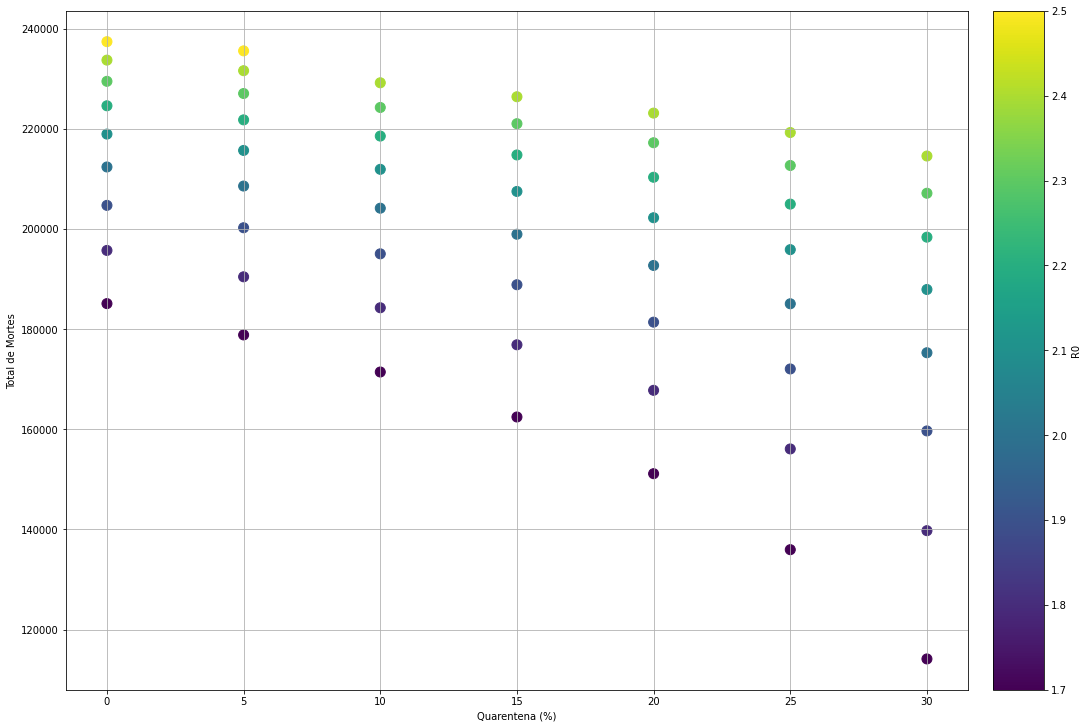

In [213]:
fig,ax = subplots(1,1, figsize=(15,10), constrained_layout=True)
suma.plot.scatter(x='Quarentena', y='morte_total',s=100,c='R0',cmap='viridis', ax=ax,grid=True );
# suma.plot(x='Quarentena', y='morte_total',style='k:',ax=ax)
plt.ylabel('Total de Mortes')
plt.xlabel('Quarentena (%)');

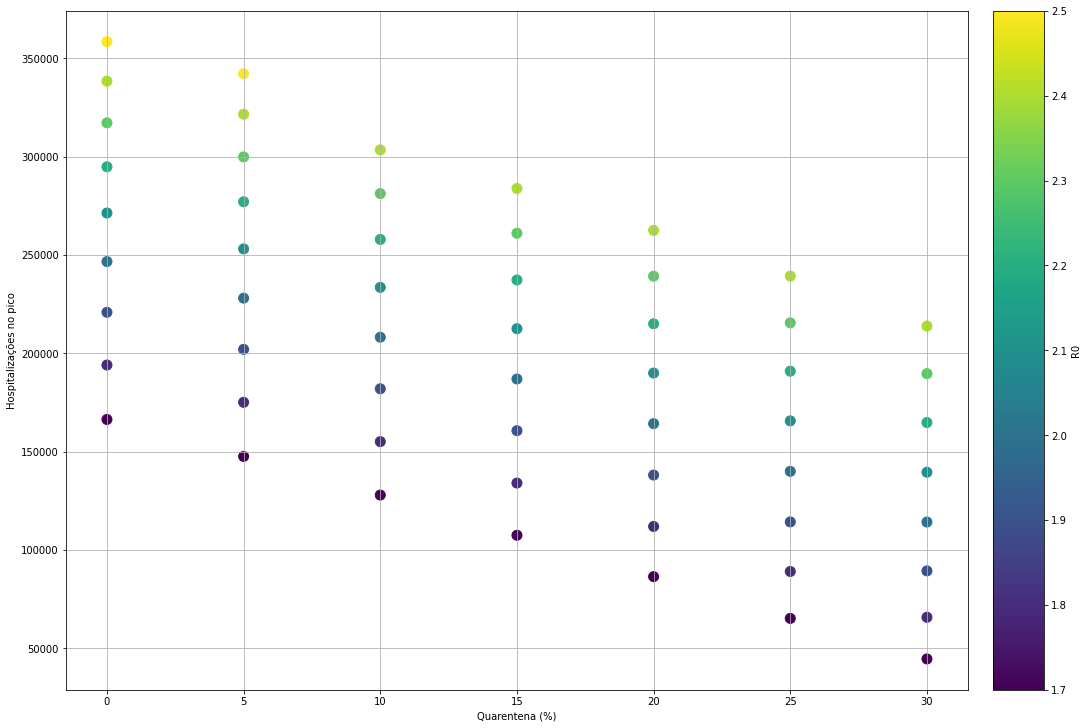

In [224]:
fig,ax = subplots(1,1, figsize=(15,10), constrained_layout=True)
suma.plot.scatter(x='Quarentena', y='hosp_pico',s=100,c='R0',cmap='viridis', ax=ax,grid=True );
plt.ylabel('Hospitalizações no pico')
plt.xlabel('Quarentena (%)');

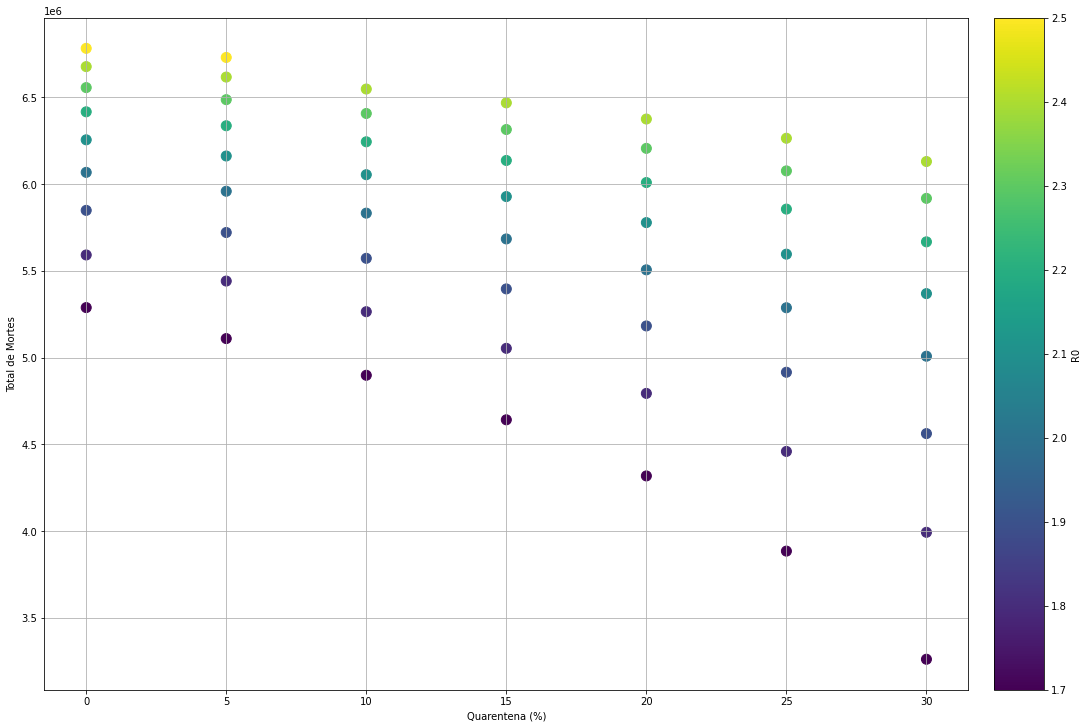

In [215]:
fig,ax = subplots(1,1, figsize=(15,10), constrained_layout=True)
suma.plot.scatter(x='Quarentena', y='hosp_total',s=100,c='R0',cmap='viridis', ax=ax,grid=True );
plt.ylabel('Total de Mortes')
plt.xlabel('Quarentena (%)');

## Carregando os dados do Brasil

In [461]:
# Pegando os casos do Brasil.io
cases = pd.read_csv('https://brasil.io/dataset/covid19/caso?format=csv')
cases.date = pd.to_datetime(cases.date)

In [462]:
df_states = cases[cases.place_type!='state'].groupby(['date','state']).sum()
df_states.reset_index(inplace=True)
df_states.set_index('date', inplace=True)

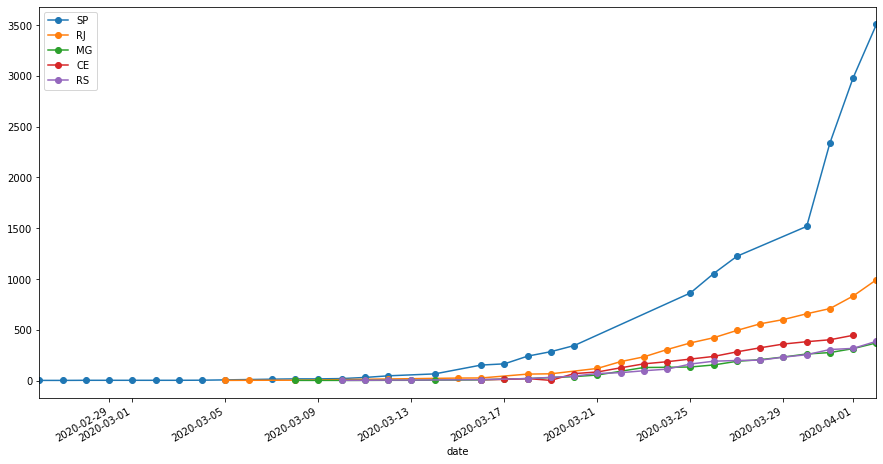

In [464]:
# df_states.set_index('date', inplace=True)
fig,ax = subplots(1,1,figsize=(15,8))
for uf in ['SP','RJ','MG','CE','RS']:
    df_states[df_states.state==uf].confirmed.plot(style='-o', label=uf)

ax.legend()
plt.savefig('export/Casos_confirmados_estados.png',dpi=200)

In [478]:
# Pegando os dados do Ministério
casos = pd.read_csv('COVID19_20200402.csv',sep=';')
casos.data = pd.to_datetime(casos.data, dayfirst=True)
casos_estados = casos.groupby(['data','estado']).sum()
casos_estados

casosNovos  casosAcumulados  obitosNovos  obitosAcumulados
data       estado                                                            
2020-01-30 AC               0                0            0                 0
           AL               0                0            0                 0
           AM               0                0            0                 0
           AP               0                0            0                 0
           BA               0                0            0                 0
...                       ...              ...          ...               ...
2020-04-02 RS              28              334            1                 5
           SC              12              247            0                 2
           SE               3               23            2                 2
           SP             525             3506           24               188
           TO               0               12            0                 0

[1728 rows x 4 columns]

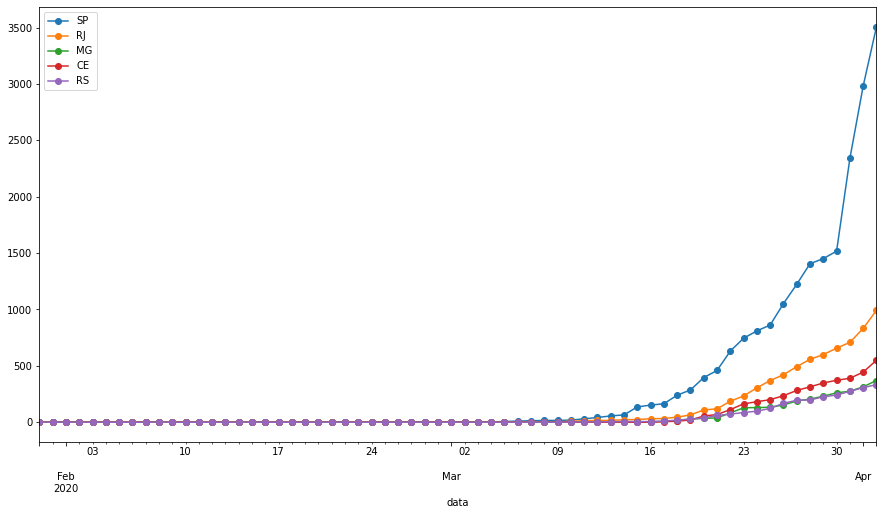

In [479]:
fig,ax = subplots(1,1,figsize=(15,8))
casos_estados.reset_index(inplace=True)
casos_estados.set_index('data', inplace=True)
for uf in ['SP','RJ','MG','CE','RS']:
    casos_estados[casos_estados.estado==uf].casosAcumulados.plot(style='-o', label=uf)

ax.legend()
plt.savefig('export/Casos_Acumulados_estados.png',dpi=200)

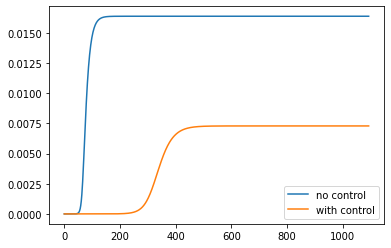

In [555]:
trange = arange(0,1095,1)
χ=0.0;φ=.01;β=.38;ρ=.6;δ=.1;α=10; p=.75
inits = [0.99,0,1.0277e-8, 0.0,0,0,0]
res = odeint(seqiahr,inits,trange,args=(χ,φ,β,ρ,δ,α,p))
# Com controle
χ=0.1;β=.17
res_c = odeint(seqiahr,inits,trange,args=(χ,φ,β,ρ,δ,α,p))
plt.plot(trange,res[:,-1],label='no control');
plt.plot(trange,res_c[:,-1],label='with control');
plt.legend();

In [487]:
df_brasil = casos_estados.groupby('data').sum()
# df_brasil['casos_simulados']=res[:dias,-1]*N
# dfcp = df_brasil[['confirmed']]
# dfcp.to_csv('export/dados_brasil.csv')
df_brasil

,casosNovos,casosAcumulados,obitosNovos,obitosAcumulados
data,,,,
2020-01-30,0,0,0,0
2020-01-31,0,0,0,0
2020-02-01,0,0,0,0
2020-02-02,0,0,0,0
2020-02-03,0,0,0,0
...,...,...,...,...
2020-03-29,353,4256,22,136
2020-03-30,323,4579,23,159
2020-03-31,1138,5717,42,201


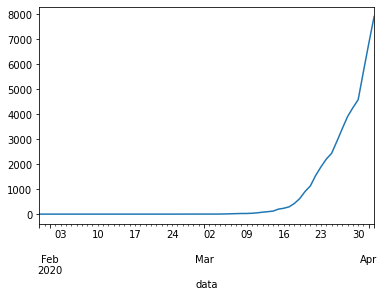

In [498]:
df_brasil.casosAcumulados.plot();

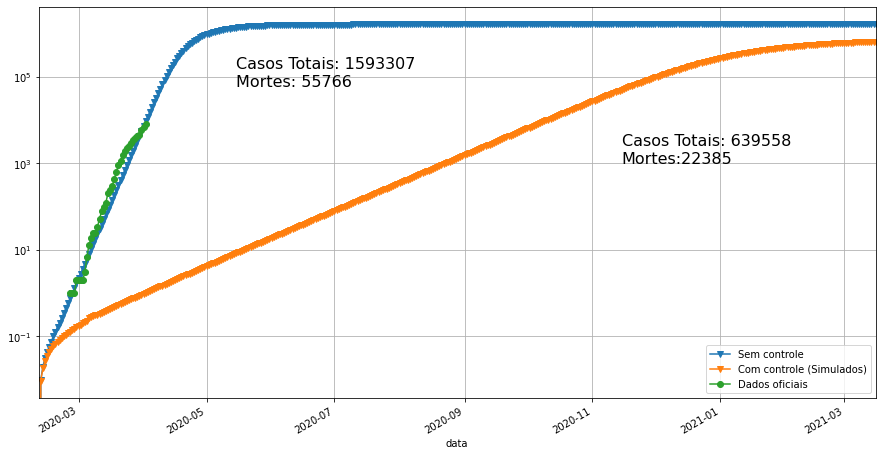

In [551]:
dias=400
offset = 15 # quantos dias antes do primeir caso notificado devemos começar a simulaçao
drange = pd.date_range(df_brasil[df_brasil.casosAcumulados>0].index.min()-timedelta(offset),periods=dias,freq='D')
# df_states.reset_index(inplace=True)
# df_brasil = df_states.groupby('date').sum()
fig,ax = subplots(1,1,figsize=(15,8))
ax.plot(drange,res[:dias,-1]*N,'-v', label='Sem controle')
ax.plot(drange,res_c[:dias,-1]*N,'-v', label='Com controle (Simulados)')
# ax.plot(drange,res[:dias,2]*N,'-^', label='Prevalência')
df_brasil[df_brasil.casosAcumulados>0].casosAcumulados.plot(ax=ax, style='-o', 
                                                            label='Dados oficiais',
                                                            grid=True, 
                                                            logy=True)
# Sem controle
ax.text('2020-05-15',0.6e5, f'Casos Totais: {res[dias,-1]*N:.0f}\nMortes: {res[dias,-1]*N*fat:.0f}', 
        fontsize=16)
# com 10% quarentena e R0=1.7
ax.text('2020-11-15',1e3, f'Casos Totais: {res_c[dias,-1]*N:.0f}\nMortes:{res_c[dias,-1]*N*fat:.0f}', 
        fontsize=16)
ax.legend()
plt.savefig('export/Casos_vs_Projeções_log.png',dpi=200)

In [556]:
df_sim = pd.DataFrame(data={'sem controle':res[:dias,-1]*N,'com controle':res_c[:dias,-1]*N}, index=drange)
df_sim.to_csv('export/simulação_brasil_com_e_sem_controle.csv')

In [326]:
N

97300000.0

In [536]:
from datetime import timedelta
df_brasil.index.min()-timedelta(15)

Timestamp('2020-01-15 00:00:00')